In [1]:
%matplotlib inline
%reload_ext autoreload

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")
sns.set_context("talk")

In [4]:
epoch_key = 'Jaq', 3, 12

In [ ]:
from dask.distributed import Client

# for virga
client = Client(n_workers=8, threads_per_worker=8, processes=True)

client

In [5]:
from src.load_data import load_data


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=30,
                 min_distance_traveled=50,
                 )

07-Dec-21 17:15:04 Loading position info...
07-Dec-21 17:15:56 Loading multiunit...
07-Dec-21 17:16:21 Loading spikes...
07-Dec-21 17:16:28 Finding ripple times...


In [6]:
import numpy as np

detector_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'spike_model_knot_spacing': 8.0,
    'spike_model_penalty': 0.5,
    'movement_state_transition_type': 'random_walk',
    'multiunit_model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])},
    'multiunit_occupancy_kwargs': {'bandwidth': np.array([8.0])},
    'discrete_state_transition_type': 'constant',
    'discrete_diagonal': np.array([0.00003, 0.968])
}

In [7]:
from replay_identification import ReplayDetector
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING

replay_detector = ReplayDetector(**detector_parameters)
logging.info(replay_detector)

replay_detector.fit(
    is_ripple=data['is_ripple'],
    is_training=~data['is_ripple'].values.squeeze(),
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    track_graph=data['track_graph'],
    edge_order=WTRACK_EDGE_ORDER,
    edge_spacing=WTRACK_EDGE_SPACING,
)

detector_results = replay_detector.predict(
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    use_likelihoods=['spikes'],
    use_acausal=True)

07-Dec-21 17:17:12 ReplayDetector(discrete_diagonal=array([3.00e-05, 9.68e-01]),
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=8.0,
               spike_model_penalty

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

07-Dec-21 17:22:57 Finding causal non-local probability and position...
07-Dec-21 17:23:06 Finding acausal non-local probability and position...


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from scipy.stats import zscore


def plot_detector(time_ind, data, replay_detector, detector_results,
                  figsize=(11, 6.0)):
    fig, axes = plt.subplots(6, 1,
                             figsize=figsize,
                             sharex=True,
                             constrained_layout=True,
                             gridspec_kw={
                                 'height_ratios': [1, 1, 3, 1, 3, 1]},
                            dpi=100)
    time = data['spikes'].iloc[time_ind].index / np.timedelta64(1, 's')
    
    # axes 0
    # max_consensus = np.ceil(zscore(data['ripple_consensus_trace'], nan_policy='omit').values.max()).astype(int)
    start_time = data['spikes'].iloc[time_ind].index.min()
    end_time = data['spikes'].iloc[time_ind].index.max()
    ripple_consensus_trace = zscore(data['ripple_consensus_trace'], nan_policy='omit').loc[start_time:end_time]
    
    max_consensus = max(int(np.ceil(ripple_consensus_trace.max())), 5)
    min_consensus = min(int(np.ceil(ripple_consensus_trace.min())), -1)
    ripple_consensus_trace_time = ripple_consensus_trace.index / np.timedelta64(1, 's')
    
    axes[0].fill_between(
        time, np.ones_like(time) * max_consensus,
        where=data['ripple_labels'].iloc[time_ind].values.squeeze() > 0,
        color='red', zorder=-2, alpha=0.6, step='pre')
    axes[0].fill_between(
        ripple_consensus_trace_time,
        ripple_consensus_trace.values.squeeze(), color='black')
    axes[0].set_ylim((min_consensus, max_consensus))
    axes[0].set_yticks((min_consensus, max_consensus))
    axes[0].set_ylabel("Ripple\nSTd.")
    
    # axes 1
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(
            data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )
    max_multiunit = np.ceil(data["multiunit_firing_rate"].values.max()).astype(int)
    axes[1].fill_between(
        multiunit_firing.iloc[time_ind].index.values,
        multiunit_firing.iloc[time_ind].values.squeeze(),
        color="black",
    )
    axes[1].fill_between(
        time, np.ones_like(time) * max_multiunit,
        where=data["multiunit_high_synchrony_labels"].iloc[time_ind].values.squeeze() > 0,
        color='blue', zorder=-2, alpha=0.6, step='pre')
    axes[1].set_ylim((0, max_multiunit))
    axes[1].set_yticks((0, max_multiunit))
    axes[1].set_ylabel("Multiunit\nRate\n[spikes / s]")

    # axes 2
    place_fields = (
        replay_detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze()
    place_field_max = np.nanargmax(place_fields, axis=0)
    linear_position_order = place_field_max.argsort(axis=0).squeeze()
    spike_time_ind, neuron_ind = np.nonzero(
        np.asarray(data['spikes'].iloc[time_ind])[:, linear_position_order])

    axes[2].scatter(time[spike_time_ind], neuron_ind,
                    clip_on=False, s=10, color='black', marker='|', rasterized=True)
    axes[2].set_ylim((0, place_fields.shape[1]))
    axes[2].set_yticks((0, place_fields.shape[1]))
    axes[2].set_ylabel('Cells')
    axes[2].fill_between(
        time, np.ones_like(time) * place_fields.shape[1],
        where=detector_results.isel(time=time_ind).non_local_probability >= 0.80,
        color='green', zorder=-1, alpha=0.6, step='pre')
    
    # axes 3
    detector_results.isel(time=time_ind).non_local_probability.plot(
        x='time', ax=axes[3], color='black', clip_on=False)
    axes[3].set_ylabel('Prob.')
    axes[3].set_xlabel("")
    axes[3].set_ylim((0, 1))

    cmap = copy.copy(plt.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    # axes 4
    (detector_results
     .isel(time=time_ind)
     .acausal_posterior
     .sum('state')
     .where(replay_detector.is_track_interior_)
     .plot(x='time', y='position', ax=axes[4], cmap=cmap,
           vmin=0.0, vmax=0.05))
    axes[4].scatter(data['position_info'].iloc[time_ind].index /
                    np.timedelta64(1, 's'),
                    data['position_info'].iloc[time_ind].linear_position,
                    s=1,
                    color='magenta', clip_on=False)
    axes[4].set_xlabel("")
    max_position = np.ceil(data['position_info'].linear_position.max()).astype(int)
    axes[4].set_yticks((0.0, max_position))
    axes[4].set_ylim((0.0, max_position))
    axes[4].set_ylabel('Position [cm]')
    
    # axes 5
    speed = np.asarray(data['position_info'].iloc[time_ind].nose_vel).squeeze()
    max_speed = np.ceil(speed.max()).astype(int)
    max_speed = max(5, max_speed)
    axes[5].fill_between(time, speed, color='grey')
    axes[5].axhline(4, color='black', linestyle='--', linewidth=1)
    axes[5].set_ylabel('Speed\n[cm / s]')
    axes[5].set_yticks((0.0, max_speed))
    axes[5].set_ylim((0.0, max_speed))
    
    axes[-1].set_xlabel('Time [s]')
    axes[-1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    sns.despine(offset=5)

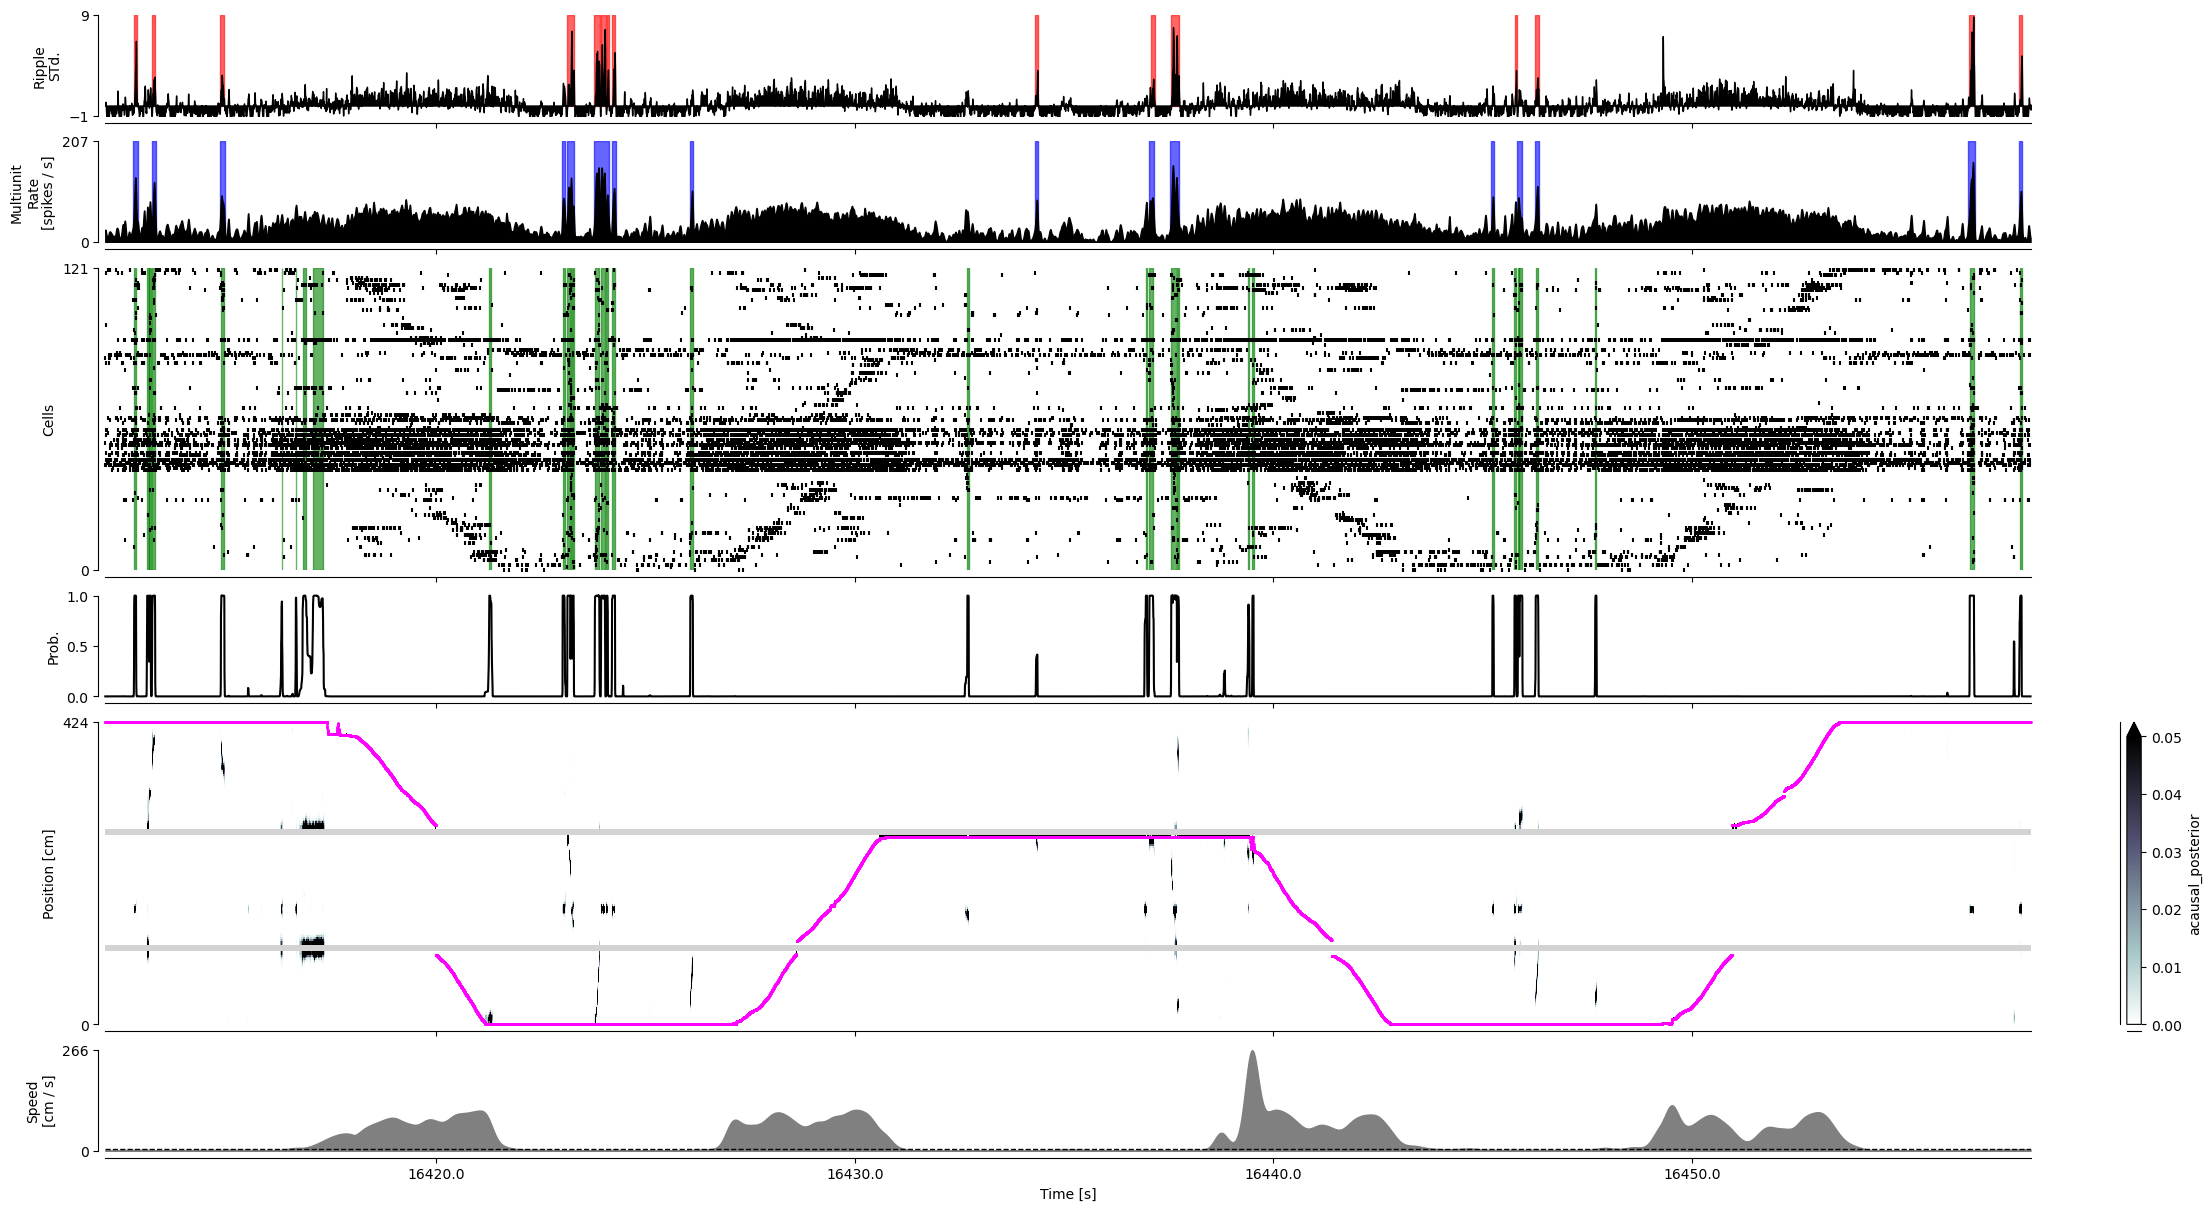

In [9]:
time_slice = slice(22_000, 45_000)
plot_detector(time_slice, data, replay_detector, detector_results, figsize=(22, 12.0))

In [ ]:
from replay_identification import ReplayDetector
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING
from sklearn.utils import resample
from tqdm.autonotebook import tqdm

def bootstrap_detector(detector_parameters, data, n_bootstrap=1):

    detectors = []
    results = []
    for sample_ind in tqdm(range(n_bootstrap)):
        detector = ReplayDetector(**detector_parameters)

        is_training = ~data['is_ripple'].values.squeeze()
        position = np.asarray(data['position_info'].linear_position.copy())
        spikes = np.asarray(data['spikes'].copy())
        position[is_training], spikes[is_training] = resample(
            position[is_training], spikes[is_training])
        speed = data['position_info'].nose_vel

        detector.fit(
            is_ripple=data['is_ripple'],
            is_training=is_training,
            speed=speed,
            position=position,
            spikes=spikes,
            track_graph=data['track_graph'],
            edge_order=WTRACK_EDGE_ORDER,
            edge_spacing=WTRACK_EDGE_SPACING,
        )

        detectors.append(detector)

        results.append(detector.predict(
            speed=data['position_info'].nose_vel,
            position=data['position_info'].linear_position,
            spikes=data['spikes'],
            time=data['position_info'].index / np.timedelta64(1, 's'),
            use_likelihoods=['spikes'],
            use_acausal=True))

    return detectors, results

detectors, results = bootstrap_detector(detector_parameters, data, n_bootstrap=100)

  0%|          | 0/100 [00:00<?, ?it/s]

07-Dec-21 18:00:54 Fitting speed model...
07-Dec-21 18:00:56 Fitting spiking model...
07-Dec-21 18:04:48 Fitting replay movement state transition...
07-Dec-21 18:04:49 Fitting replay state transition...
07-Dec-21 18:04:49 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

07-Dec-21 18:06:09 Finding causal non-local probability and position...
07-Dec-21 18:06:17 Finding acausal non-local probability and position...
07-Dec-21 18:06:49 Fitting speed model...
07-Dec-21 18:06:50 Fitting spiking model...
07-Dec-21 18:11:01 Fitting replay movement state transition...
07-Dec-21 18:11:02 Fitting replay state transition...
07-Dec-21 18:11:02 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

07-Dec-21 18:12:21 Finding causal non-local probability and position...
07-Dec-21 18:12:31 Finding acausal non-local probability and position...
07-Dec-21 18:13:07 Fitting speed model...
07-Dec-21 18:13:08 Fitting spiking model...
07-Dec-21 18:17:17 Fitting replay movement state transition...
07-Dec-21 18:17:17 Fitting replay state transition...
07-Dec-21 18:17:17 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

07-Dec-21 18:18:37 Finding causal non-local probability and position...
07-Dec-21 18:18:46 Finding acausal non-local probability and position...
07-Dec-21 18:19:15 Fitting speed model...
07-Dec-21 18:19:17 Fitting spiking model...
07-Dec-21 18:23:24 Fitting replay movement state transition...
07-Dec-21 18:23:25 Fitting replay state transition...
07-Dec-21 18:23:25 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

07-Dec-21 18:24:44 Finding causal non-local probability and position...
07-Dec-21 18:24:53 Finding acausal non-local probability and position...
07-Dec-21 18:25:30 Fitting speed model...
07-Dec-21 18:25:31 Fitting spiking model...
07-Dec-21 18:29:25 Fitting replay movement state transition...
07-Dec-21 18:29:25 Fitting replay state transition...
07-Dec-21 18:29:25 Predicting spikes likelihood...


neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

07-Dec-21 18:30:44 Finding causal non-local probability and position...
07-Dec-21 18:30:54 Finding acausal non-local probability and position...
07-Dec-21 18:31:31 Fitting speed model...
07-Dec-21 18:31:32 Fitting spiking model...


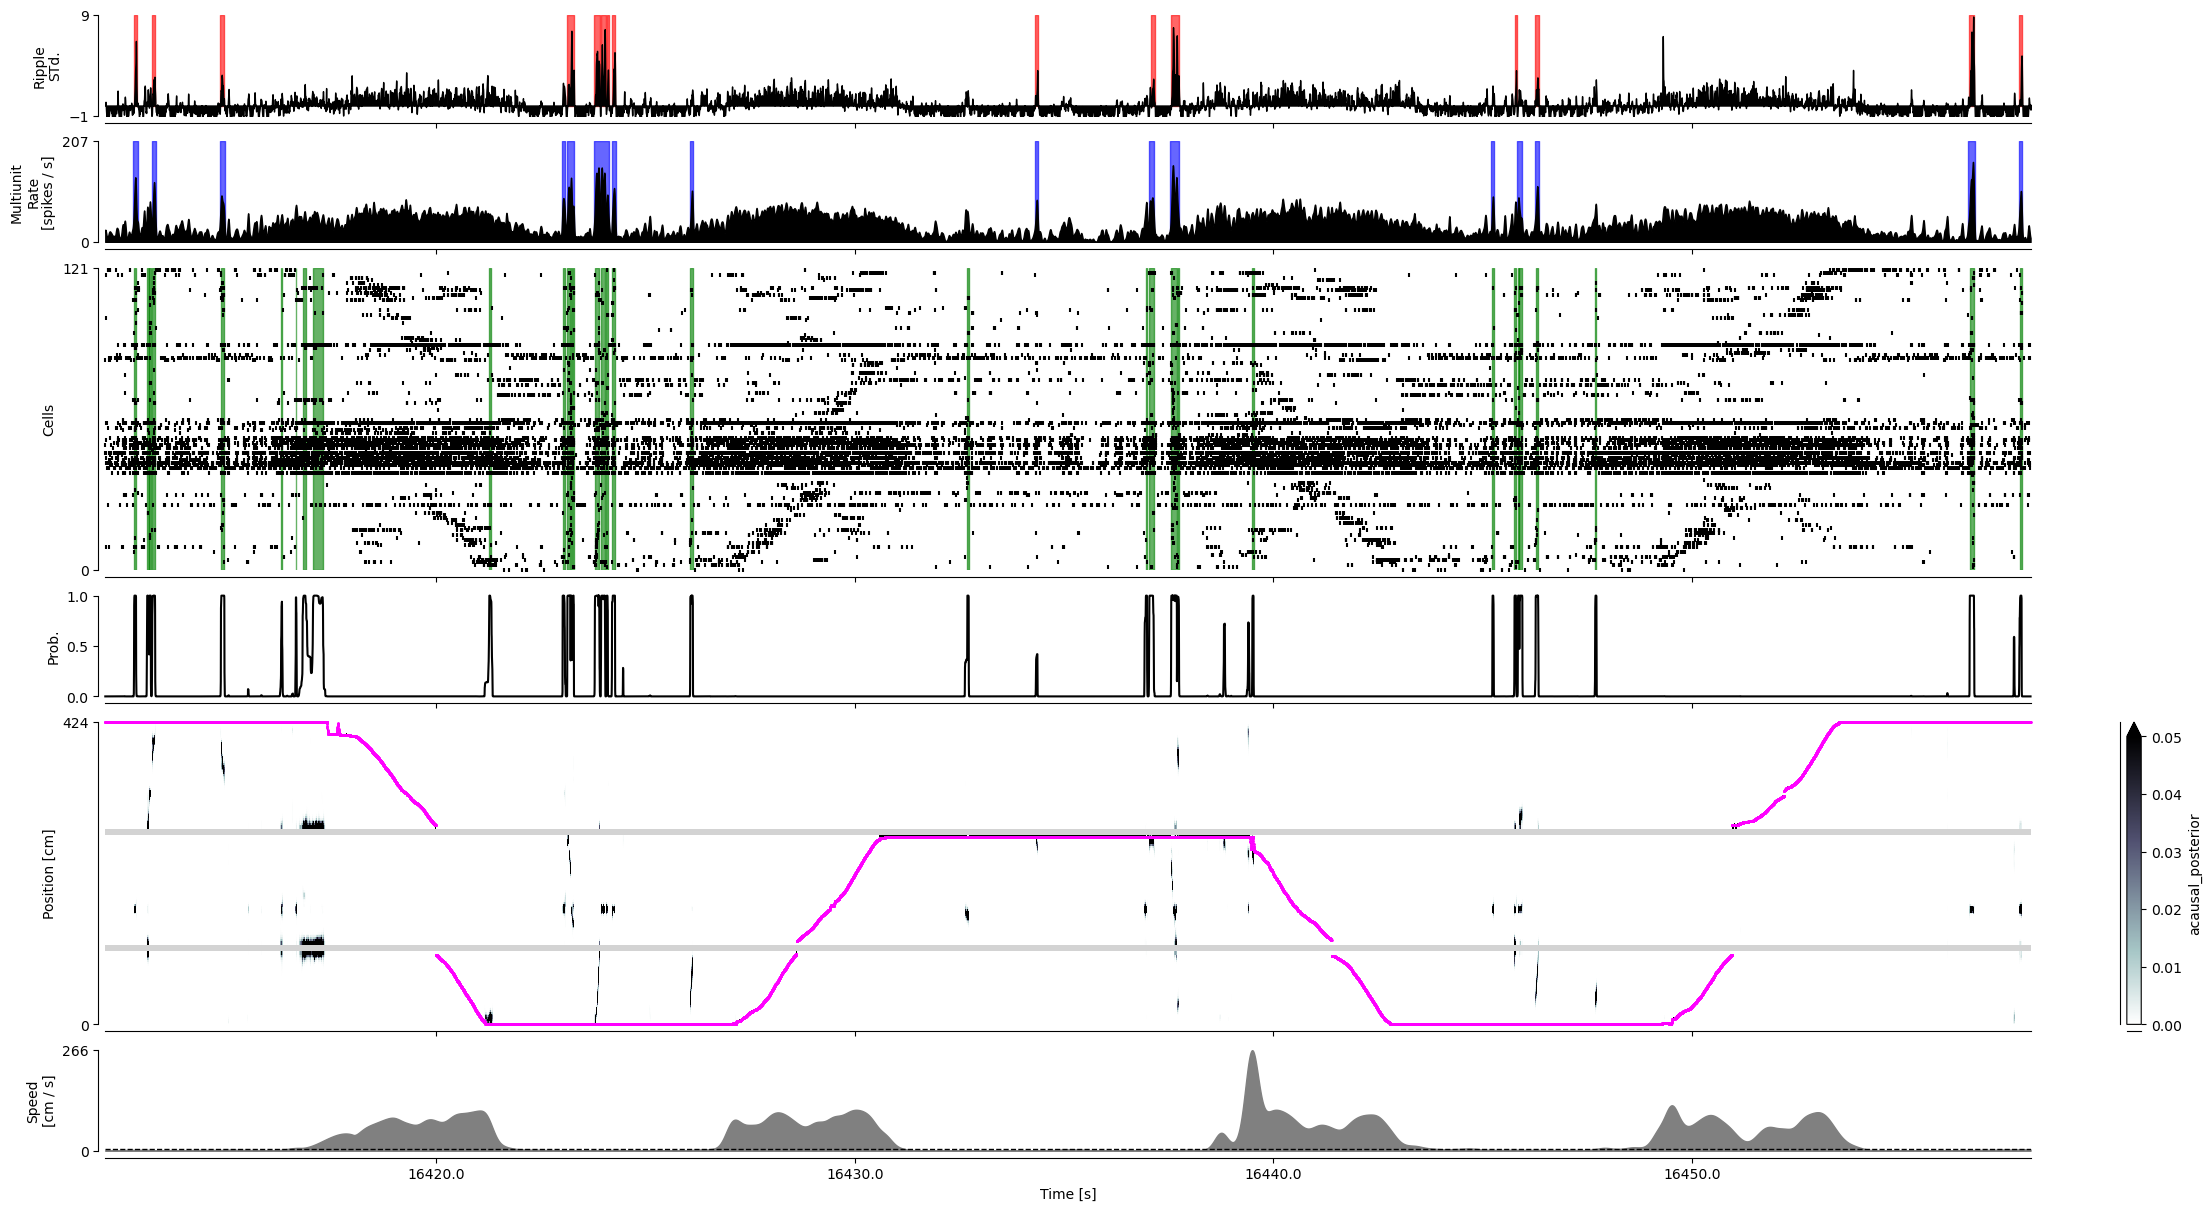

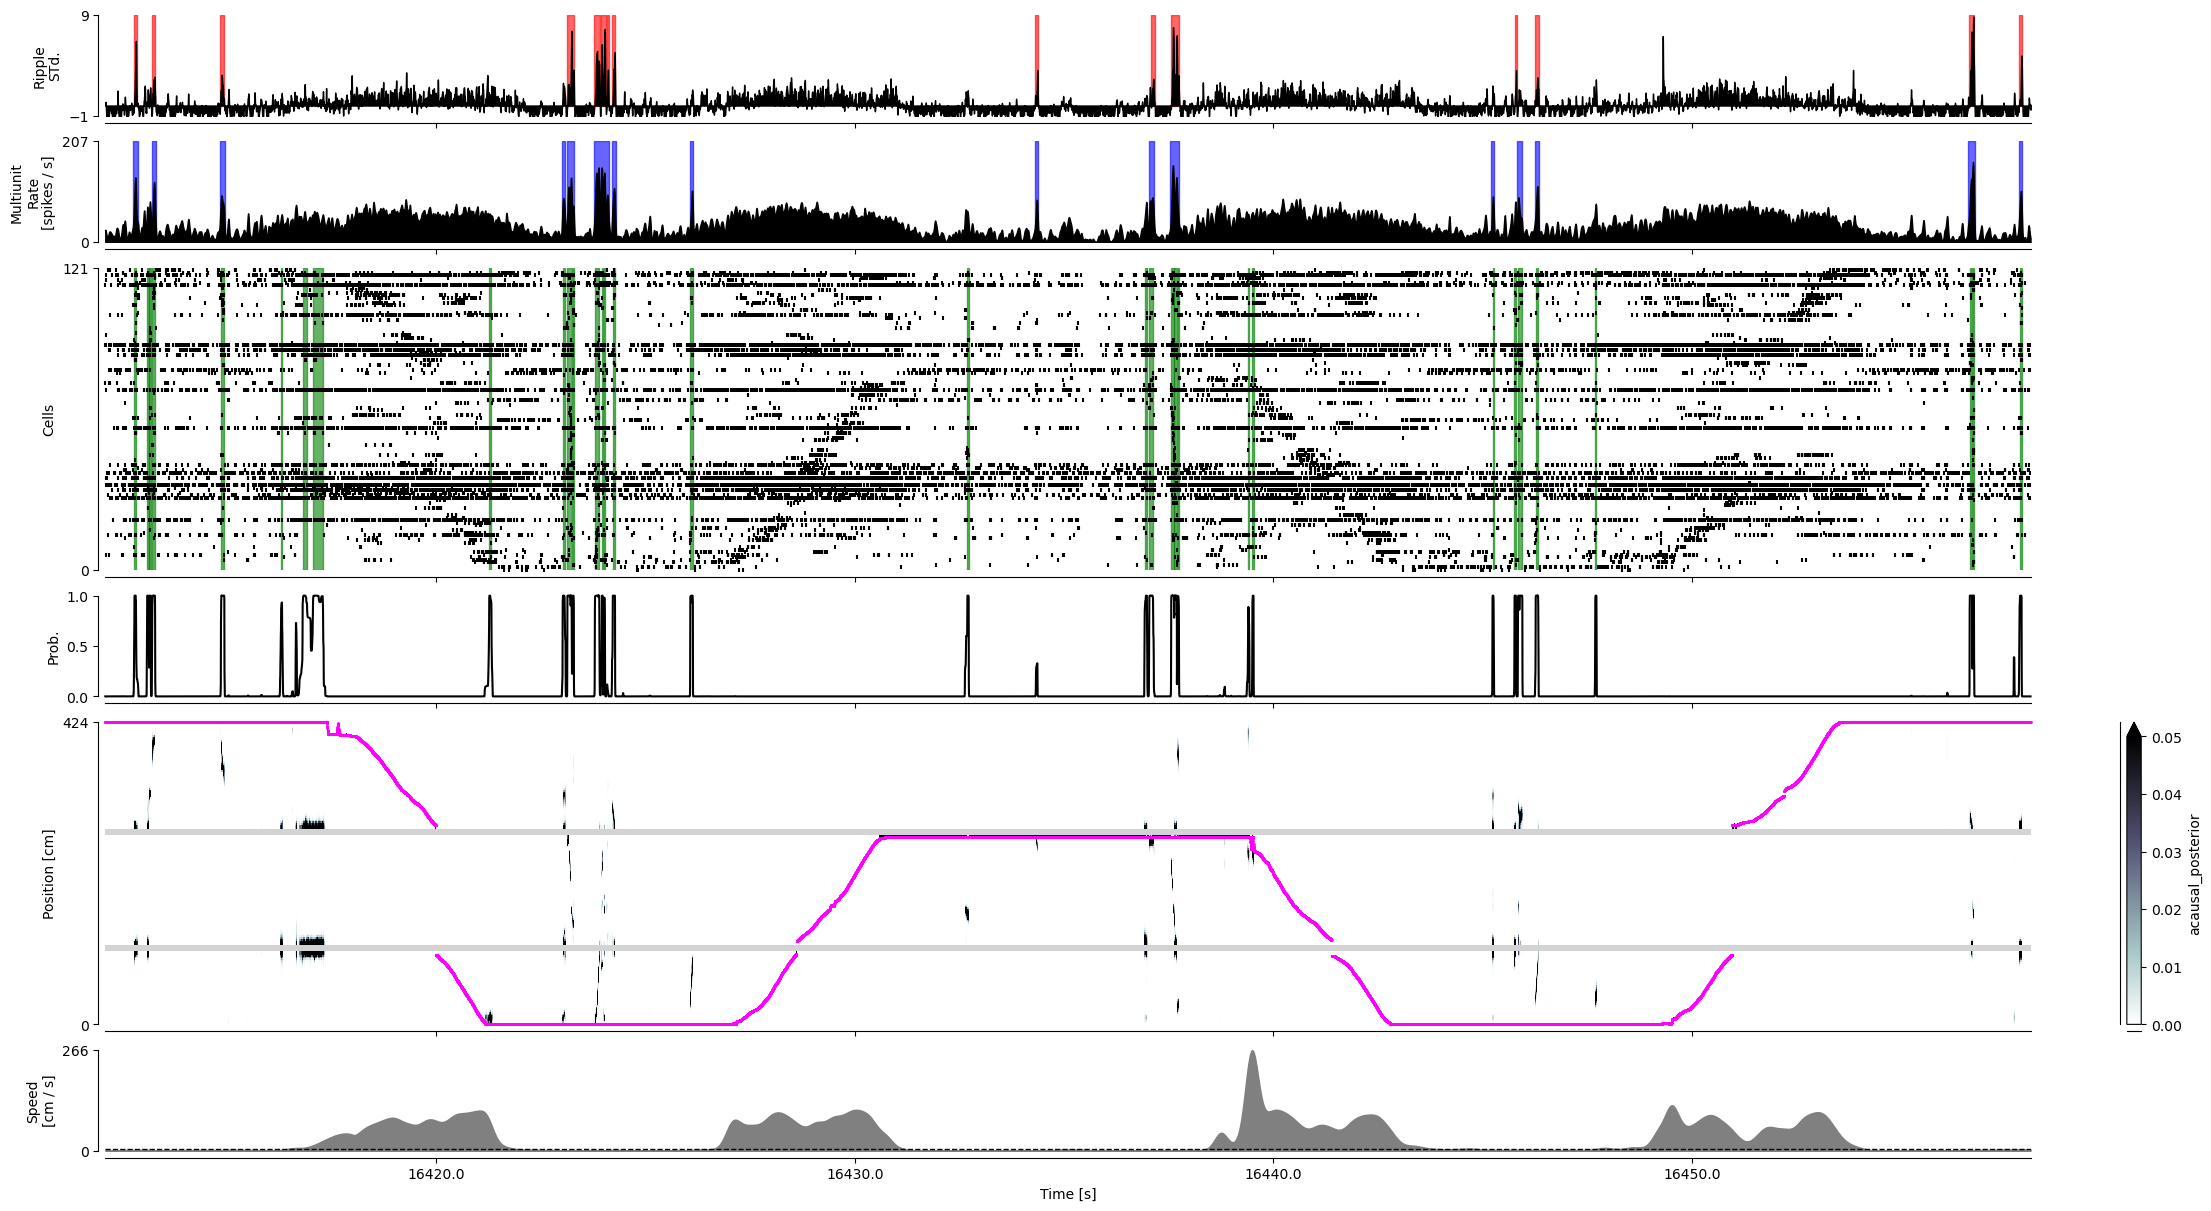

In [17]:
time_slice = slice(22_000, 45_000)
for detector, result in zip(detectors, results):
    plot_detector(time_slice, data, detector, result, figsize=(22, 12.0))

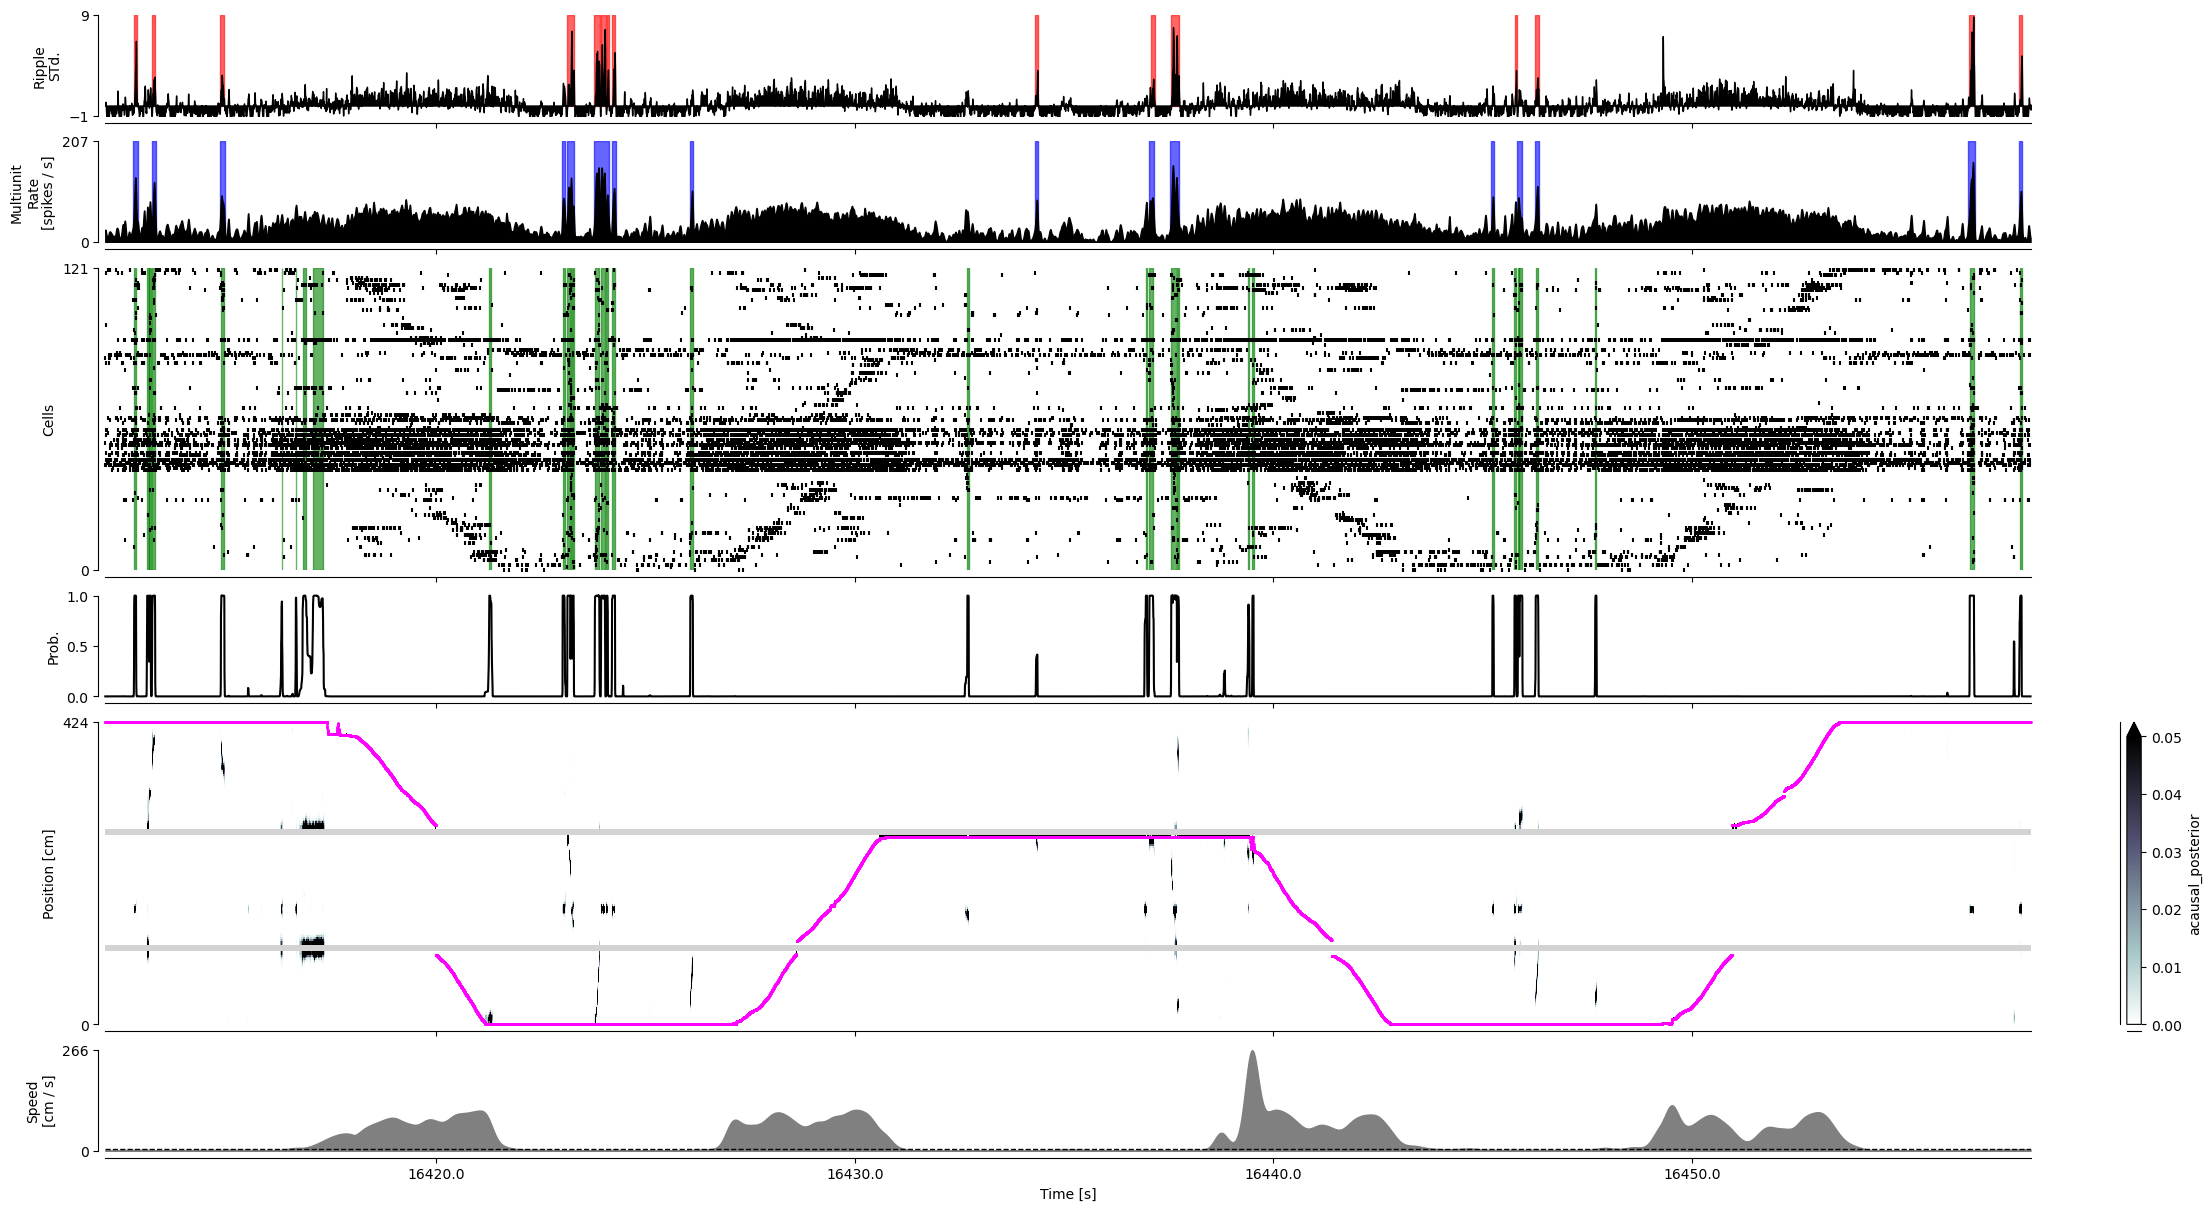

In [13]:
time_slice = slice(22_000, 45_000)
plot_detector(time_slice, data, replay_detector, detector_results, figsize=(22, 12.0))

In [1]:
time_slice = slice(22_000, 45_000)

fig, ax = plt.subplots(figsize=(20, 5))
detector_results.isel(time=time_slice).non_local_probability.plot(
        x='time', ax=ax, color='black', zorder=10, clip_on=False)

for detector, result in zip(detectors, results):
    detector_results.isel(time=time_slice).non_local_probability.plot(
        x='time', ax=ax, color='grey', zorder=1, alpha=0.5, clip_on=False)
    
ax.set_ylabel('Prob.')
ax.set_xlabel("")
ax.set_ylim((0, 1))

sns.despine()

NameError: name 'plt' is not defined

NameError: name 'replay_detector' is not defined

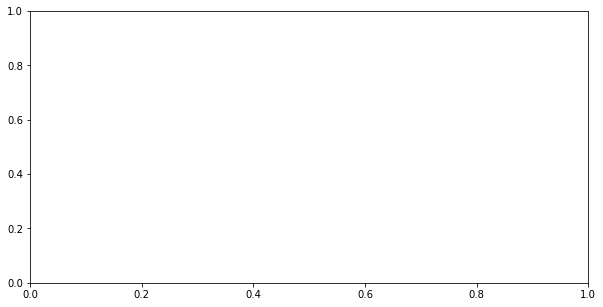

In [2]:
neuron_ind = 85

fig, ax = plt.subplots(figsize=(10, 5))

place_conditional_intensity = (
    replay_detector._spiking_likelihood
    .keywords['place_conditional_intensity']).squeeze().copy()
place_conditional_intensity[~replay_detector.is_track_interior_] = np.nan
ax.plot(replay_detector.place_bin_centers_, place_conditional_intensity[:, neuron_ind] * 500,
        color='black', zorder=10)


for detector, result in zip(detectors, results):
    place_conditional_intensity = (
        detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze().copy()
    place_conditional_intensity[~detector.is_track_interior_] = np.nan
    ax.plot(detector.place_bin_centers_, place_conditional_intensity[:, neuron_ind] * 500,
            alpha=0.5, color='grey', zorder=1)


ax.set_xlabel('Position [cm]')
ax.set_ylabel('Rate [spikes / s]')